# Distributed Analysis: A Simple Example

In [1]:
# Required imports and setup
from rootpy.plotting import Hist, Canvas, set_style
import rootpy.plotting.root2matplotlib as rplt
from root_numpy import array2hist
from IPython.parallel import Client

client = Client('ipcontroller-client.json', sshserver="--redacted--.unimelb.edu.au")
set_style('ATLAS')

INFO:rootpy.plotting.style:using ROOT style 'ATLAS'


In [2]:
# check that the cluster is up and running (expect a response from three laptops)
client[:].apply_sync(lambda: "Hello world!")

['Hello world!', 'Hello world!', 'Hello world!']

## Write the analysis code

Loop on CMS dimuon events in a CSV file and calculate the dimuon invariant mass. These events were extracted from the CMS Mu Primary Dataset on the CERN Open Data Portal: http://opendata.cern.ch/record/14. Thanks to http://openstack.cern.ch for providing a CernVM running SL5 where I could set up CMSSW 4.2.8 and to https://github.com/tpmccauley/dimuon-filter for generating the CSV from CMS AODs.

In [3]:
def analysis(filename):
    import csv
    from math import sqrt
    from rootpy.plotting import Hist
    from root_numpy import hist2array

    h = Hist(1500, 0.5, 120)

    with open(filename, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        header = reader.next()
        column = dict([(header[i], i) for i in range(len(header))])

        for row in reader:
            charge1 = int(row[column['Q1']])
            charge2 = int(row[column['Q2']])
            opposite_charge = charge1 * charge2 == -1
            if not opposite_charge:
                continue

            E1 = float(row[column['E1']])
            px1 = float(row[column['px1']])
            py1 = float(row[column['py1']])
            pz1 = float(row[column['pz1']])

            E2 = float(row[column['E2']])
            px2 = float(row[column['px2']])
            py2 = float(row[column['py2']])
            pz2 = float(row[column['pz2']])

            E = E1 + E2
            px = px1 + px2
            py = py1 + py2
            pz = pz1 + pz2
            m2 = E**2 - (px**2 + py**2 + pz**2)
            if m2 < 0:
                # Bad event...
                continue
            h.Fill(sqrt(m2))
            
    # Return the ROOT histogram as a numpy array
    return hist2array(h)

In [4]:
def plot(arrays, hist):
    # sum the histograms from each worker
    total_hist = sum([array2hist(array, hist.Clone()) for array in arrays])
    # plot!
    canvas = Canvas()
    canvas.SetLogy()
    canvas.SetLogx()
    total_hist.xaxis.title = 'M_{#mu#mu} [GeV]'
    total_hist.yaxis.title = 'Events'
    total_hist.Draw('hist')
    return canvas

## Execute the analysis on a single local core

Run our analysis function on the full CSV file on a single core of this computer.

In [5]:
%time local_array = analysis('MuRun2010B.csv')

CPU times: user 1min 25s, sys: 2.18 s, total: 1min 27s
Wall time: 1min 28s


That took about 1.5 minutes... Looking at the plot of the dimuon invariant mass below, we see the usual suspects. How many can you name?

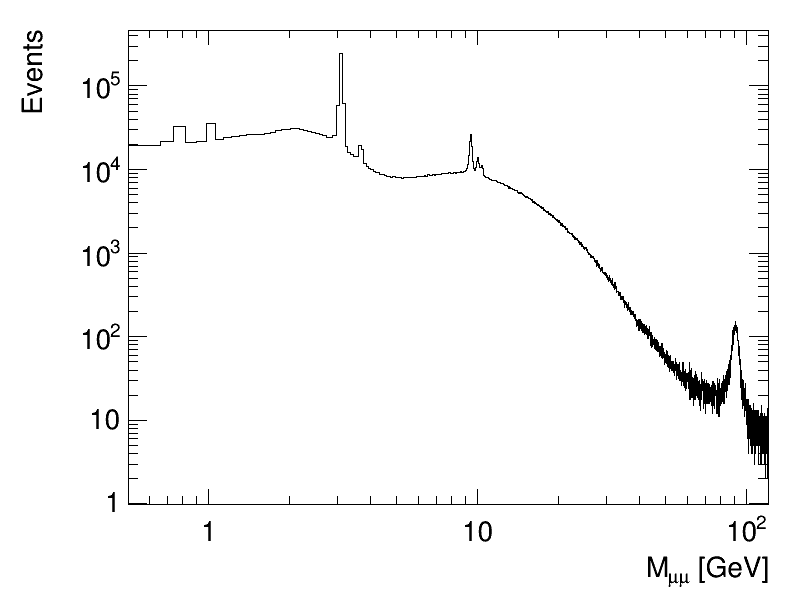

In [6]:
plot([local_array], Hist(1500, 0.5, 120))

## Distributed execution

Now let's dispatch the analysis function to three worker laptops that each hold one-third of the full CSV file.

In [7]:
%time arrays = client[:].apply_sync(analysis, 'events.csv')

CPU times: user 5.84 s, sys: 416 ms, total: 6.25 s
Wall time: 31.4 s


That took about 30 seconds. That's three times as fast as the local execution above. Of course we should expect the same plot shown below:

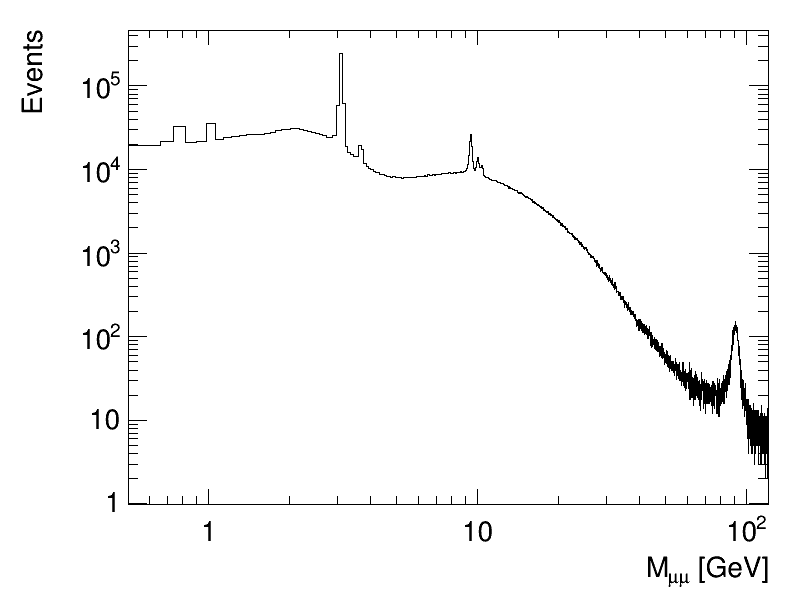

In [8]:
plot(arrays, Hist(1500, 0.5, 120))